Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# Support Vector Machines

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

# Support Vector Machine Classifier

* A support vector machine [SVM](https://en.wikipedia.org/wiki/Support-vector_machine) classifier is a non-probability classifier.
* Attempts to separate classes of observations by finding the hyperplane in the space of features that best divides the two classes, that separates them by the largest "margin".
    Hence, SVMs are "margin classifiers."
* Can also be used for _unsupervised_ learning, i.e., for clustering.

Here's an illustration borrowed from [Data Camp](https://www.datacamp.com/):

![SVM example](./images/svm-datacamp-ex.png)

SVMs can be trained, tweaked, and evaluated like binary logistic regression machine learners, and other kinds of machine learners, can.

In the following we're going to apply SVMs to a [cervical cancer dataset](https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29) available on the [UCI ML repository](https://archive.ics.uci.edu/ml/index.php)

The indicated citation: Kelwin Fernandes, Jaime S. Cardoso, and Jessica Fernandes. 'Transfer Learning with Partial Observability Applied to Cervical Cancer Screening.' Iberian Conference on Pattern Recognition and Image Analysis. Springer International Publishing, 2017. ([paper link](http://inescporto.pt/~jsc/publications/conferences/2017KelwinIBPRIA.pdf))

# Getting Essentials

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Markdown
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import linear_model  
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_score, recall_score
from sklearn.svm import SVC  # support vector classifier
import os
import shelve
%matplotlib inline

# The Data

The data are in a headered csv file that may be in the pwd, or in a data subirectory. We'll input it into a Pandas DataFrame, examine the data, select some variables to use, and then we'll extract from our DataFrame the numpy arrays we need.

In [2]:
cervical=pd.read_csv('../DATA/ML/risk_factors_cervical_cancer.csv')

In [3]:
# get a look at what we've got
cervical.shape
cervical.columns
cervical.dtypes
cervical.describe()

(858, 36)

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

Age                                    int64
Number of sexual partners             object
First sexual intercourse              object
Num of pregnancies                    object
Smokes                                object
Smokes (years)                        object
Smokes (packs/year)                   object
Hormonal Contraceptives               object
Hormonal Contraceptives (years)       object
IUD                                   object
IUD (years)                           object
STDs                                  object
STDs (number)                         object
STDs:condylomatosis                   object
STDs:cervical condylomatosis          object
STDs:vaginal condylomatosis           object
STDs:vulvo-perineal condylomatosis    object
STDs:syphilis                         object
STDs:pelvic inflammatory disease      object
STDs:genital herpes                   object
STDs:molluscum contagiosum            object
STDs:AIDS                             object
STDs:HIV  

,Age,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,0.087413,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,0.302545,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


It would appear the missing values in the data are codes with a question mark, ?.  That would explain the variables that are type "object."  This type is essentially just a char type, and it's what Pandas defaults to when it can't figure out what numeric type an input variable might be.

To set the ? to np.nan's, numpy missing value codes, we can read the csv file again.

In [4]:
cervical=pd.read_csv('../DATA/ML/risk_factors_cervical_cancer.csv',na_values='?')

In [5]:
cervical.dtypes
cervical.dtypes.value_counts()

Age                                     int64
Number of sexual partners             float64
First sexual intercourse              float64
Num of pregnancies                    float64
Smokes                                float64
Smokes (years)                        float64
Smokes (packs/year)                   float64
Hormonal Contraceptives               float64
Hormonal Contraceptives (years)       float64
IUD                                   float64
IUD (years)                           float64
STDs                                  float64
STDs (number)                         float64
STDs:condylomatosis                   float64
STDs:cervical condylomatosis          float64
STDs:vaginal condylomatosis           float64
STDs:vulvo-perineal condylomatosis    float64
STDs:syphilis                         float64
STDs:pelvic inflammatory disease      float64
STDs:genital herpes                   float64
STDs:molluscum contagiosum            float64
STDs:AIDS                         

float64    26
int64      10
dtype: int64

Looks like the ? are now gone. Let's check for missings values:

In [6]:
cervical.isnull().sum(axis=0)

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

## Missing values

Missing values can be dealt with in various ways.  Values can be predicted, or "imputed," for them using various methods, including:

* replacing them with a measure of central tendency, e.g., the mean computed from non-missing values;
* imputing them using a supervised learning algorithm like k-nearest neighbors ("KNN") or RandomForest
* removing observations with missing values.

For our present purposes, we're just going to remove cases with missing values.

## Selecting Features

Let's use the following as the features we'll use for prediction:

In [7]:
cervicalFeats=cervical.loc[:,'Age':'Hormonal Contraceptives (years)'].copy()

According to the available documentation, there are four "target" variables.  Here are their relative frequencies in this dataset:

In [8]:
cervical.loc[:,"Hinselmann":"Biopsy"].apply(np.sum,axis=0)/len(cervical)

Hinselmann    0.040793
Schiller      0.086247
Citology      0.051282
Biopsy        0.064103
dtype: float64

Note that all these putative results are infrequent in this data.  Classifiers tend to struggle when trying to predict rare events.  

In what follows we'll work with `Biopsy` as the target to be predicted. Let's put this target variable together with the features we'll use to predict it, in a new DataFrame that we'll drop rows with any missing values from.

In [9]:
cervical.columns
cervical.shape
cervical2=pd.concat([cervical.Biopsy,cervicalFeats],axis=1).dropna(axis=0)
cervical2.columns
cervical2.shape
# cervical2.describe()

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

(858, 36)

Index(['Biopsy', 'Age', 'Number of sexual partners',
       'First sexual intercourse', 'Num of pregnancies', 'Smokes',
       'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)'],
      dtype='object')

(676, 10)

Looks good enough for government work.  Let's create the numpy arrays we'll need for training our SVM.

In [11]:
X=cervical2.iloc[:,1:].to_numpy()  # features cervicalFeats
y=cervical2.iloc[:,0].to_numpy()  # target cervical.Biopsy
X.shape
y.shape

(676, 9)

(676,)

# Support Vector Classifier

Here we'll do simple k-fold cross-validation of our classifier.  We'll then get predictions for our cross-validated model, and we'll use them for plotting ROC curves and doing precision-recall plots.

## Cross-Validation

In [12]:
svclf=SVC(probability=True)   #instance of the support vector classifier
svcRes=cross_validate(svclf,X,y,cv=20,n_jobs=-1,return_train_score=True)

In [13]:
# Let's take a look at performance
pd.DataFrame(svcRes).describe()

,fit_time,score_time,test_score,train_score
count,20.000000,20.000000,20.000000,20.000000
mean,0.106085,0.001838,0.932218,0.941375
std,0.005869,0.000496,0.012064,0.001568
min,0.100470,0.001354,0.914286,0.937792
25%,0.103007,0.001432,0.914286,0.940810
50%,0.104936,0.001591,0.939394,0.940902
75%,0.106183,0.002156,0.939394,0.942390
max,0.124223,0.002871,0.941176,0.943838


## But, Why?  

Looks like a really accurate classifier, for sure.  But, the positive class of the `Biopsy` target variable is rare, i.e., there are very few cases for which `Biopsy` = 1. 

Let's take a look at the confusion matrix, an ROC curve, AUC, and a precision-recall plot.

In [14]:
# First, get predicted probabilites for the target labels

yPredProb=cross_val_predict(svclf,X,y,n_jobs=-1,cv=20,
                           method='predict_proba')

In [15]:
# What's returned is an N X 2 numpy array containing predicted label probabilities.
# Here's the first 8 rows.  The second col is the probability that Biopsy = 1:

yPredProb

array([[0.93649739, 0.06350261],
       [0.93553425, 0.06446575],
       [0.93034738, 0.06965262],
       ...,
       [0.93374213, 0.06625787],
       [0.93941497, 0.06058503],
       [0.92849902, 0.07150098]])

## Confusion Matrix

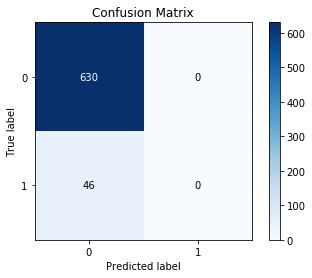

In [16]:
skplt.metrics.plot_confusion_matrix(y, yPredProb[:,1]>0.5,
                                    normalize=False);

Ugh!  Here's a different version:

In [17]:
confusion_matrix(y, yPredProb[:,1]>0.5)

array([[630,   0],
       [ 46,   0]])

So, our model is correct almost all the time by just predicting `Biopsy` = 0.  Let's take a look at the ROC. AUC will be in the legend of this plot.

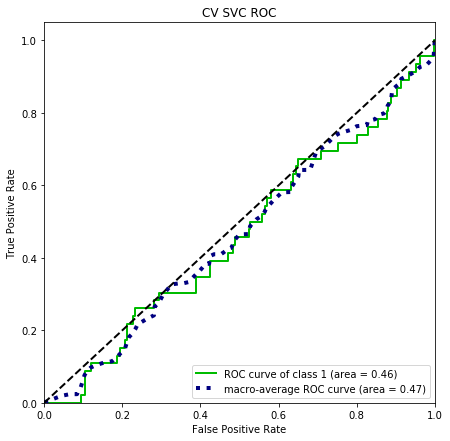

In [18]:
skplt.metrics.plot_roc(y, yPredProb, title="CV SVC ROC",
                      figsize=(7,7),plot_micro=False,
                      classes_to_plot=1)
plt.show();

## Precision and Recall

You'll recall that:  

**Precision** = proportion of cases classified as positive that are actually positive  
**Recall** = proportion of positive cases that are classified as positive

Here are the precision and recall estimates for the current results:

In [19]:
print('Precision: {:5.3f} Recall: {:5.3f}'.format(
        precision_score(y,yPredProb[:,1]>0.5),
        recall_score(y,yPredProb[:,1]>0.5)))

Precision: 0.000 Recall: 0.000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Pretty sucky.

## Unbalanced Class Label Tweak

One way of trying to get a better classifier model for an "unbalanced" target is to weight observations based on target class frequencies.  This is akin to using class prior probabilities, or penalizing a likelihood function. In this case, the weights are actually applied to a shrinkage parameter (see "C" in the [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) documentation.  C defaults to 1.0.  We'll give this tweak a try here.

위에서 보았듯이 unbalanced class label에서는 negative로 예측할 가능성이 매우 높기 때문에 balanced 해주는 것이 중요하다.   
```python
class_weight = "balanced"
```
를 써줌으로써 balance가 가능하다. 하지만...

In [20]:
# Here's our SVC with target classes weighted by frequency of occurrance.
svclf2=SVC(probability=True,class_weight='balanced')   #instance of the support vector classifier
svcRes2=cross_validate(svclf2,X,y,cv=20,n_jobs=-1,return_train_score=True)

In [21]:
# covert to code cell to get DataFrame of results

pd.DataFrame(svcRes2).describe()

,fit_time,score_time,test_score,train_score
count,20.000000,20.000000,20.000000,20.000000
mean,0.139287,0.001559,0.844794,0.919266
std,0.017748,0.000271,0.065695,0.008304
min,0.123995,0.001394,0.727273,0.909798
25%,0.128641,0.001453,0.796970,0.912840
50%,0.131752,0.001490,0.878788,0.918287
75%,0.136182,0.001508,0.885714,0.922027
max,0.179556,0.002399,0.939394,0.945398


In [22]:
yPredProb2=cross_val_predict(svclf2,X,y,n_jobs=-1,cv=20,
                           method='predict_proba')

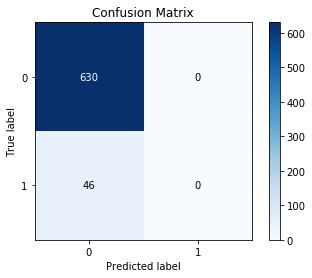

In [23]:
skplt.metrics.plot_confusion_matrix(y, yPredProb2[:,1]>0.5,
                                    normalize=False);

In [24]:
confusion_matrix(y, yPredProb2[:,1]>0.5)

array([[630,   0],
       [ 46,   0]])

Not really any better. Not an uncommon result when doing machine learning, unfortunately. And all ML classifiers struggle with very unbalanced distributions of target variable labels.  Also, note the difference model performance between training and test CV folds. (There are other ways to do this, btw):

In [25]:
def difCols(x):
    return(x[0]-x[1])

pd.DataFrame(svcRes2)[['train_score','test_score']].apply(
    difCols,axis=1).describe()

count    20.000000
mean      0.074472
std       0.069270
min      -0.029596
25%       0.029262
50%       0.040052
75%       0.127751
max       0.191856
dtype: float64

When a model's accuracy decreases when it is applied to "new" data, data it hasn't "seen" before, it can be symptomatic of _over-fitting_ the training data.

# A UDU 4 U: Something to Try

A source of variation might result from the way that CV was done, here.  Try using _stratified_ K fold cross-validation here to see what difference it might make.

A QUESTION:  Do you think that adding additional features to your SVM model would improve its performance?

ANOTHER QUESTION: Would _increasing_ the amount of regulatization result in any improvement?

# What, Now?

Various tactics can be used to deal with extremely unbalanced target label classes.  They include "data augmentation" (adding additional data to the rare class), synthesizing cases for the rare class (AKA "making up data," but perhaps more defensible), downsampling (reducing the prevalent class), and various specialized algorithms. 

A frequently used technique:

[SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/pdf/1106.1813.pdf)

See also:

[SMOTE for high-dimensional class-imbalanced
data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/pdf/1471-2105-14-106.pdf)

Here's a Python package that includes many such tools: [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/user_guide.html#).

## Shelving Cervical Data

We'll serialize some of the data we've worked with here for subsequent use.  If we can't access this shelve database for some reason, we can just read the csv file again. (Less fun, though.)

[reference](http://www.incodom.kr/%ED%8C%8C%EC%9D%B4%EC%8D%AC/%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC/shelve)

In [26]:
cervicaldb='cervical'
with shelve.open(cervicaldb) as sdb:
    sdb['cervical']=cervical
    sdb['cervical2']=cervical2
    sdb['X']=X
    sdb['y']=y
sdb.close()